In [1]:
# import the packages used for analysis
import nltk
import pandas as pd
import numpy as np
import string
import regex as re

import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import feature_extraction, model_selection, metrics, svm

In [2]:
import datetime
import spacy
import math

In [3]:
data = pd.read_csv('Consumer_Discretionary_and_traditional.csv')      # reading data

In [4]:
data.head(5)

,Unnamed: 0,Time,Title,SubTitle,Declined Offer,Neutral Experience,Average Interview,Application,Interview,InterviewQuestions,date
0,1,"Apr 26, 2022",Barista Interview,"Anonymous Interview Candidate in Sarasota, FL",neutral,good,good,I applied online. I interviewed at Starbucks (...,"East, quick, simple questions. The person I me...",Tell us about your previous experience.,2022-04-26
1,2,"Apr 26, 2022",Barista Interview,Anonymous Employee,good,good,good,I interviewed at Starbucks,The interview process was very simple and I en...,Tell me a little about yourself?,2022-04-26
2,3,"Apr 25, 2022",Barista Interview,"Anonymous Employee in Roseville, CA",good,good,good,I applied in-person. I interviewed at Starbuck...,Interview was fairly easy. It was just a simpl...,What are some duties you believe a barista has?,2022-04-25
3,4,"Apr 25, 2022",Barista - Starbucks Interview,"Anonymous Employee in Albuquerque, NM",good,good,good,I applied online. I interviewed at Starbucks (...,one on one Interview with the store manager. V...,Best part of thee job in your opinion.,2022-04-25
4,5,"Apr 25, 2022",Barista Interview,"Anonymous Interview Candidate in Iowa City, IA",neutral,good,good,I applied online. The process took 2 weeks. I ...,Received a phone call from manager and came in...,How do you work with a team?,2022-04-25


In [5]:
data['combined'] = data['Interview'] + ' ' +  data['InterviewQuestions']
data.iloc[0].combined

'East, quick, simple questions. The person I met with was kind and respectful. Hours are random though. I did not end up taking the position even though I was offered the job. Tell us about your previous experience.'

In [6]:
data.loc[data.date <= '2019-12-31', 'period'] = 1
data.loc[(data.date > '2019-12-31') & (data.date <= '2020-06-30'), 'period'] = 2
data.loc[data.date > '2020-06-30', 'period'] = 3
data['period_count'] = data.groupby('period')['date'].transform(lambda a: len(set(a)))

#### Initialize data

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32187 entries, 0 to 32186
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          32187 non-null  int64  
 1   Time                32187 non-null  object 
 2   Title               32187 non-null  object 
 3   SubTitle            32187 non-null  object 
 4   Declined Offer      32187 non-null  object 
 5   Neutral Experience  32187 non-null  object 
 6   Average Interview   32187 non-null  object 
 7   Application         32187 non-null  object 
 8   Interview           32187 non-null  object 
 9   InterviewQuestions  32171 non-null  object 
 10  date                32187 non-null  object 
 11  combined            32171 non-null  object 
 12  period              32187 non-null  float64
 13  period_count        32187 non-null  int64  
dtypes: float64(1), int64(2), object(11)
memory usage: 3.4+ MB


array([[<AxesSubplot:title={'center':'bad'}>,
        <AxesSubplot:title={'center':'good'}>],
       [<AxesSubplot:title={'center':'neutral'}>, <AxesSubplot:>]],
      dtype=object)

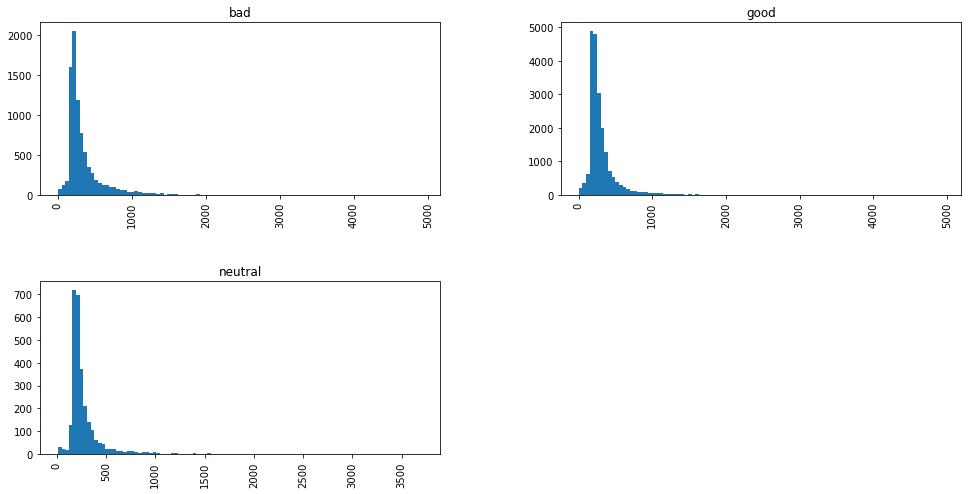

In [8]:
data['length'] = data['Interview'].apply(len)
data.hist(column='length',by='Declined Offer',bins=100, figsize=(16,8))

In [9]:
# Checking null/missing values
data.isnull().sum()

Unnamed: 0             0
Time                   0
Title                  0
SubTitle               0
Declined Offer         0
Neutral Experience     0
Average Interview      0
Application            0
Interview              0
InterviewQuestions    16
date                   0
combined              16
period                 0
period_count           0
length                 0
dtype: int64

In [10]:
data.InterviewQuestions

0                  Tell us about your previous experience.
1                         Tell me a little about yourself?
2          What are some duties you believe a barista has?
3                   Best part of thee job in your opinion.
4                             How do you work with a team?
                               ...                        
32182    What are your plans to turn around the sales i...
32183                           I didnt have an interview.
32184           How familiar are you with a P&L Statement?
32185    The most unexpected interview question I was a...
32186    The most difficult question had to do with my ...
Name: InterviewQuestions, Length: 32187, dtype: object

In [11]:
data = data.fillna("")
data

,Unnamed: 0,Time,Title,SubTitle,Declined Offer,Neutral Experience,Average Interview,Application,Interview,InterviewQuestions,date,combined,period,period_count,length
0,1,"Apr 26, 2022",Barista Interview,"Anonymous Interview Candidate in Sarasota, FL",neutral,good,good,I applied online. I interviewed at Starbucks (...,"East, quick, simple questions. The person I me...",Tell us about your previous experience.,2022-04-26,"East, quick, simple questions. The person I me...",3.0,664,174
1,2,"Apr 26, 2022",Barista Interview,Anonymous Employee,good,good,good,I interviewed at Starbucks,The interview process was very simple and I en...,Tell me a little about yourself?,2022-04-26,The interview process was very simple and I en...,3.0,664,224
2,3,"Apr 25, 2022",Barista Interview,"Anonymous Employee in Roseville, CA",good,good,good,I applied in-person. I interviewed at Starbuck...,Interview was fairly easy. It was just a simpl...,What are some duties you believe a barista has?,2022-04-25,Interview was fairly easy. It was just a simpl...,3.0,664,186
3,4,"Apr 25, 2022",Barista - Starbucks Interview,"Anonymous Employee in Albuquerque, NM",good,good,good,I applied online. I interviewed at Starbucks (...,one on one Interview with the store manager. V...,Best part of thee job in your opinion.,2022-04-25,one on one Interview with the store manager. V...,3.0,664,183
4,5,"Apr 25, 2022",Barista Interview,"Anonymous Interview Candidate in Iowa City, IA",neutral,good,good,I applied online. The process took 2 weeks. I ...,Received a phone call from manager and came in...,How do you work with a team?,2022-04-25,Received a phone call from manager and came in...,3.0,664,293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32182,1427,"Oct 13, 2010",General Manager Interview,"Anonymous Employee in Phoenix, AZ",good,neutral,neutral,The process took 1 day. I interviewed at Domin...,I already had experience as a GM for a franchi...,What are your plans to turn around the sales i...,2010-10-13,I already had experience as a GM for a franchi...,1.0,3593,569
32183,1428,"Aug 18, 2010",Dominos Delivery Driver Interview,"Anonymous Employee in Logan, UT",good,good,good,I applied in-person. The process took 1 day. I...,I simply walked in to the local Domino's and a...,I didnt have an interview.,2010-08-18,I simply walked in to the local Domino's and a...,1.0,3593,182
32184,1429,"Aug 13, 2010",Assistant Manager Interview,"Anonymous Interview Candidate in Pensacola, FL",bad,bad,good,The process took 1 day. I interviewed at Domin...,I applied online and heard from the company ab...,How familiar are you with a P&L Statement?,2010-08-13,I applied online and heard from the company ab...,1.0,3593,1749
32185,1430,"Jul 29, 2010",Customer Service Representative Interview,Anonymous Employee in MISSING VALUE,good,neutral,good,I applied through an employee referral The pro...,My manager picks people at random for intervie...,The most unexpected interview question I was a...,2010-07-29,My manager picks people at random for intervie...,1.0,3593,251


In fact, the two texts in this experiment were not exactly equal; their ratio was 2:1. But this is the case where I've combined two data sources, and I think that's enough.

#### Preprocess data

In [12]:
# Removing Punctutaion
def clean1(text):
    words = []
    for word in text:
        if word not in string.punctuation:
            words.append(word)
    output= "".join(words)
    return output

In [13]:
# Tokenizing
def clean3(text):
    split=re.split("\W+",text) 
    return split

In [14]:
# Removing Stopwords
stopword = set(stopwords.words('english'))
stopword.add('interview')
stopword.add('question')
stopword.add('the')
stopword.add('i')
stopword.add('recruiter')
def clean2(text):
    return " ".join([word for word in str(text).split() if word not in stopword])

In [15]:
# Tokenizing
def clean3(text):
    split=re.split("\W+",text) 
    return split

In [16]:
# Lemmatizing
'''In order to avoid that the different parts of speech of the 
same word will disturb our analysis, we need to restore their form.'''
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text])

In [17]:
data["combined"][0]

'East, quick, simple questions. The person I met with was kind and respectful. Hours are random though. I did not end up taking the position even though I was offered the job. Tell us about your previous experience.'

In [18]:
combined1 = data[data["period"] == 1]["combined"]
combined2 = data[data["period"] == 2]["combined"]
combined3 = data[data["period"] == 3]["combined"]

In [19]:
data[data["period"] == 1]["period_count"]

2008     3593
2009     3593
2010     3593
2011     3593
2012     3593
         ... 
32182    3593
32183    3593
32184    3593
32185    3593
32186    3593
Name: period_count, Length: 23271, dtype: int64

In [20]:
data[data["period"] == 2]["period_count"]

1816     174
1817     174
1818     174
1819     174
1820     174
        ... 
31179    174
31180    174
31181    174
31182    174
31183    174
Name: period_count, Length: 929, dtype: int64

In [21]:
data[data["period"] == 3]["period_count"]

0        664
1        664
2        664
3        664
4        664
        ... 
31125    664
31126    664
31127    664
31128    664
31129    664
Name: period_count, Length: 7987, dtype: int64

In [22]:
period1count=3593
period2count=174
period3count=664

In [23]:
def dataprocessing(target):
    target = target.apply(lambda x: clean1(x))
    target = target.apply(lambda x: clean3(x))
    target = target.apply(lambda x: clean2(x))
    target = target.apply(lambda x: clean3(x))
    target = target.apply(lambda text: lemmatize_words(text))
    output = " ".join(target.tolist())
    return output

In [24]:
period1combined = dataprocessing(combined1)
period2combined = dataprocessing(combined2)
period3combined = dataprocessing(combined3)

In [25]:
# Finding most repeated words in the data
def top_words(text,words,count):
    allWords = nltk.tokenize.word_tokenize(text)
    stopwords = nltk.corpus.stopwords.words('english')
    stopwords = set(stopwords)
    appendlist = {"the","i",'interviewer',"interview","wa","recruiter","process","question","one","would","1",'2','3','4','5','6','asked','got','hr'}
    stopwords.update(appendlist)
    allWordExceptStopDist = nltk.FreqDist([w.lower() for w in allWords if w.lower() not in list(stopwords)])   
    mostCommontuples= allWordExceptStopDist.most_common(words)
    mostCommon = [(tupl[0],round(tupl[1]/count,2)) for tupl in mostCommontuples]
    return mostCommon

#### High frequency words for different kinds of situations

In [26]:
type1p1 = top_words(period1combined,100,period1count)

In [27]:
type1p2 = top_words(period2combined,100,period2count)

In [28]:
type1p3 = top_words(period2combined,100,period3count)

In [29]:
def foundchange(list1,list2):
    output = {}
    for word1 in list1:
        for word2 in list2:
            if word1[0] == word2[0]:
                percentchange = round(word2[1]/word1[1] - 1,2)
                if percentchange >= 0.2 or percentchange <= -0.5:
                    output[word1[0]] = percentchange
    return output

In [30]:
def standard(lst,aimdic):
    output = {}
    total = []
    for word in aimdic.keys():
        for word1 in lst:
            if word1[0] == word:
                total.append(word1[1])
    average = sum(total) / len(total)
    for word in aimdic.keys():
        for word1 in lst:
            if word1[0] == word:
                output[word] = round(word1[1]/average,2)
    return output

In [31]:
def foundchangeforp2to3(aimdic2,aimdic3):
    output = {}
    for word2 in aimdic2.keys():
        for word3 in aimdic3.keys():
            if word2 == word3:
                output[word2] = round((aimdic3[word2])/(aimdic2[word2])-1,2)
    return output

In [32]:
change1 = foundchange(type1p1,type1p2)
print(change1)

{'manager': -0.51, 'day': -0.55, 'call': -0.55, 'store': -0.59, 'week': -0.53, 'get': -0.5, 'called': -0.6, 'went': -0.52, 'later': -0.71, 'told': -0.61, 'interviewed': -0.56, 'application': -0.5, 'next': -0.51, 'difficult': -0.61, 'second': -0.59, 'offer': -0.5, 'describe': -0.6, 'round': 0.22, 'come': -0.53, 'go': -0.54, 'service': -0.5, 'de': 2.57}


In [33]:
stand1 = standard(type1p2,foundchange(type1p1,type1p2))

In [34]:
stand2 = standard(type1p3,foundchange(type1p1,type1p2))

In [35]:
change2 = foundchangeforp2to3(standard(type1p2,foundchange(type1p1,type1p2)),standard(type1p3,foundchange(type1p1,type1p2)))

In [36]:
relatedword = ['later','offer','service','call']

In [37]:
def preplot(wordlist,changep1,changep2,intialfrequent):
    output = {}
    for word in wordlist:
        for word1 in intialfrequent:
            if word == word1[0]:
                initial = word1[1]
                p2 = round(initial * (changep1[word]+1),2)
                p3 = round(p2 * (changep2[word]+1),2)
                output[word] = [initial, p2, p3]
    return output

In [38]:
preplot(relatedword,change1,change2,type1p1)

{'later': [1.08, 0.31, 0.3],
 'offer': [0.72, 0.36, 0.34],
 'service': [0.6, 0.3, 0.3],
 'call': [1.54, 0.69, 0.68]}

In [39]:
period = ["before 2019-12-31","2019-12-31 to 2020-06-30", "after 2020-06-30"]

In [40]:
def plot(preplot,period):
    for word,change in preplot.items():
        plt.plot(period,change,label=word)
    plt.title('Word changes')
    plt.xlabel('period')
    plt.ylabel('frequency/day')
    plt.legend()

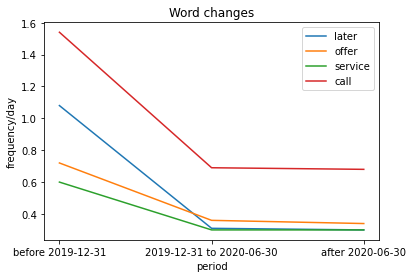

In [41]:
plot(preplot(relatedword,change1,change2,type1p1),period)